# Dataset and DataLoader

Deep learning is dependent on lots and lots of data and we need to be able to store, manage and retrieve that data. When we retrieve the data we need to make sure, that we don't go beyond the capacity of our RAM or VRAM (Video RAM). PyTorch gives us a flexible way to deal with our data pipeline the way we see fit by providing the ```Dataset``` and the ```DataLoader``` classes.

In [1]:
from torch.utils.data import Dataset, DataLoader

## Dataset

The `Dataset` object is the PyTorch representation of data. When we are dealing with real world data we subclass the ```Dataset``` class and overwrite the ```__getitem__``` and the ```__len__``` methods. Below we create a dataset that contains a list of numbers, the size of which depends on a parameter in the ```__init___``` method. The ```__getitem__``` method implements the logic, which determines how the individual element of our data should be returned given only the index of data.

In [2]:
class ListDataset(Dataset):
    def __init__(self, size):
        self.data = list(range(size))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

We can use the `ListDataset` the way we could use a list.

In [3]:
dataset = ListDataset(100)
print(len(dataset))
print(dataset[42])

100
42


In practice we could for example use the Dataset to load an image for the index received in the `__getitem__` method. Below is a dummy implementation of such a Dataset.

In [4]:
class ImagesDataset(Dataset):
    def __init__(self, images_list):
        # list containing information about the image
        # "[/images/image0.jpg", "/images/image1.jpg]"
        self.images_list = images_list
    
    def __len__(self):
        return len(self.images_list)
    
    def __getitem__(self, idx):
        file = self.images_list[idx]
        image = open_image(file)
        return image

## DataLoader

During the training process we only directly interact with the ```DataLoader``` object and not with the ```Dataset``` object. The goal of the ```DataLoader``` is to return data in batch sized pieces. Those batches can then be used for training or testing purposes.

The DataLoaser class has many parameters. Let's start with the most important parameters.

- ```dataset```: The Dataset object that implements the ```__len__``` and ```__getitem__``` interface
- ```batch_size```: size of the mini-batch used in training/testing, defaults to 1
- ```shuffle```: determines if the data is shuffled in each epoch, defaults to False

Let us generate a ListDataset with 5 elements.

In [5]:
dataset = ListDataset(5)

Next we generate a DataLoader that shuffles the dataset object and returns 2 elements at a time.

In [6]:
dataloader = DataLoader(dataset=dataset, batch_size=2, shuffle=True)

Finally we iterate through the DataLoader and receive a batch at a time. Once only one object remains, a single element is returned.

In [7]:
for epoch in range(2):
    print(f'EPOCH Nr. {epoch+1}')
    print('-' * 45)
    for batch_num, data in enumerate(dataloader):
        print(f'Batch Nr: {batch_num+1} Data: {data}')
    print()

EPOCH Nr. 1
---------------------------------------------
Batch Nr: 1 Data: tensor([3, 0])
Batch Nr: 2 Data: tensor([2, 1])
Batch Nr: 3 Data: tensor([4])

EPOCH Nr. 2
---------------------------------------------
Batch Nr: 1 Data: tensor([4, 3])
Batch Nr: 2 Data: tensor([0, 1])
Batch Nr: 3 Data: tensor([2])



Often we want our batches to always be of equal size. If a batch is too small the calculation of the gradient might be too noisy. To avoid that we can use the `drop_last` the following argument.

- ```drop_last```: removes the last batch, if it is less than ```batch_size```, defaults to False

Below we see that out of 5 samples only 4 are included in the loop if we set the ```drop_last``` variable to ```True```.

In [8]:
dataloader = DataLoader(dataset=dataset, batch_size=2, shuffle=True, drop_last=True)

In [9]:
for epoch in range(2):
    print(f'EPOCH Nr. {epoch+1}')
    print('-' * 45)
    for batch_num, data in enumerate(dataloader):
        print(f'Batch Nr: {batch_num+1} Data: {data}')
    print()

EPOCH Nr. 1
---------------------------------------------
Batch Nr: 1 Data: tensor([1, 4])
Batch Nr: 2 Data: tensor([2, 0])

EPOCH Nr. 2
---------------------------------------------
Batch Nr: 1 Data: tensor([1, 0])
Batch Nr: 2 Data: tensor([4, 3])



PyTorch gives us the ability to get the data in parallel by using subprocesses. This could be useful for example to get the next batch of data, while we are still in the process of calculating the gradients.

- ```num_workers```: integer value that determines the number of workers that get the data in parallel. The default is 0, which means that only the main process is used. 

In [10]:
dataloader = DataLoader(dataset=dataset, batch_size=2, shuffle=True, drop_last=True, num_workers=4)

We won't notice the speed difference using such a simple example, but the speedup with large datasets might be noticable.

Behind the scenes PyTorch does a load of work. In most cases the default way things are processed are sufficient, but sometimes you might need more control. We are not going to cover those details just yet, because for the most part the default ```DataLoader``` is sufficient and we will cover the special cases when the need arises. If you are faced with a problem that requires more control, you can look at the [PyTorch documentation](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).'

## MNIST

It is tradition in the deep learning community to kick off the deep learning journey, by classifying handwritten digits using the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. In this section we will only focus on the EDA (explaratory data analysis) part of the exercise. The solution to the problem will be covered the next sections.

In [11]:
import numpy as np
import matplotlib.pyplot as plt

Additionally to the common libraries like matplotlib and numpy we will use the [torchvision](https://pytorch.org/vision/stable/index.html) library. Torchvision is a part of the PyTorch stack that has a lot of useful functions for computer vision. Especially useful are the datasets that we can utilize without spending time collecting data on our own, primarily we will utilize the library to get access to the MNIST dataset.

In [12]:
from torchvision.datasets import MNIST

The torchvision MNIST class downloads the data and returns a ```Dataset``` object. 

- ```root```: folder that is used to either download the data to, or to read the data from if the data has been downloaded before
- ```train```: if True returns the train dataset, if False returns the test dataset
- ```download```: if set to True and data is not available in the root folder, will download the data into the root folder 

In [13]:
train_dataset = MNIST(root="../datasets", train=True, download=True)
test_dataset = MNIST(root="../datasets", train=False, download=False)

The Dataset can be used as an input into a ```DataLoader``` object, but for the time being we only need a couple of samples to analyze the data.

In [14]:
print(train_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../datasets
    Split: Train


Each datapoint is a tuple, consisting a PIL image and the class label.

In [15]:
print(train_dataset[0])

(<PIL.Image.Image image mode=L size=28x28 at 0x7F8FD6E93F10>, 5)


Alltogether there are 70,000 images, 60,000 training and 10,000 testing images. While this might look like a lot, modern deep learning architectures deal with millions of images. For the purpose of designing our first neural network on the other hand, MNIST is the perfect dataset. 

In [16]:
print(len(train_dataset))
print(len(test_dataset))

60000
10000


We can transform the PIL image into a NumPy array by simply using ```np.array(PIL)```.

In [17]:
img = np.array(train_dataset[0][0])

The image is 28x28 pixels.

In [18]:
img.shape

(28, 28)

When we look at the minimum and maximum pixel values, we will notice that pixel values range from 0 to 255. This is the usual range that we expect from RGB (red green blue) format. Each of the 3 channels (red channel, green channel and blue channel) can have values from 0 to 255. In our case we are only dealing with a single channel, because we are dealing with black and white images.

In [19]:
print(f'Minimum pixel value: {img.min()}')
print(f'Maximum pixel value: {img.max()}')

Minimum pixel value: 0
Maximum pixel value: 255


Let's display some of the images to get a feel for what we are dealing with.

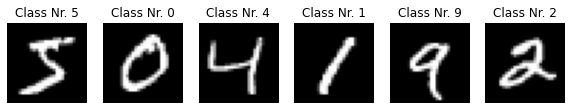

In [20]:
fig = plt.figure(figsize=(10, 10))
for i in range(6):
    fig.add_subplot(1, 6, i+1)
    img = np.array(train_dataset[i][0])
    plt.imshow(img, cmap="gray")
    plt.axis('off')
    plt.title(f'Class Nr. {train_dataset[i][1]}')
plt.show()

This task is relatively straightforward. The images are all centered and there are very few suprises in the dataset (but there are some errors). In the next section we will utilize PyTorch and train a neural network to classify those images.